In [58]:
import numpy as np 
import time 
import matplotlib.pyplot as plt
from generators.lognormal_gen import Lognormal_gen
from hypothesis import param
from hypothesis import noparam

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# <center>PLAYGROUND

In [2]:
logn_gen = Lognormal_gen(mu=0, sigma=0.5);

In [3]:
logn_gen.a, logn_gen.b 

(0.3130000000000002, 3.2009999999997585)

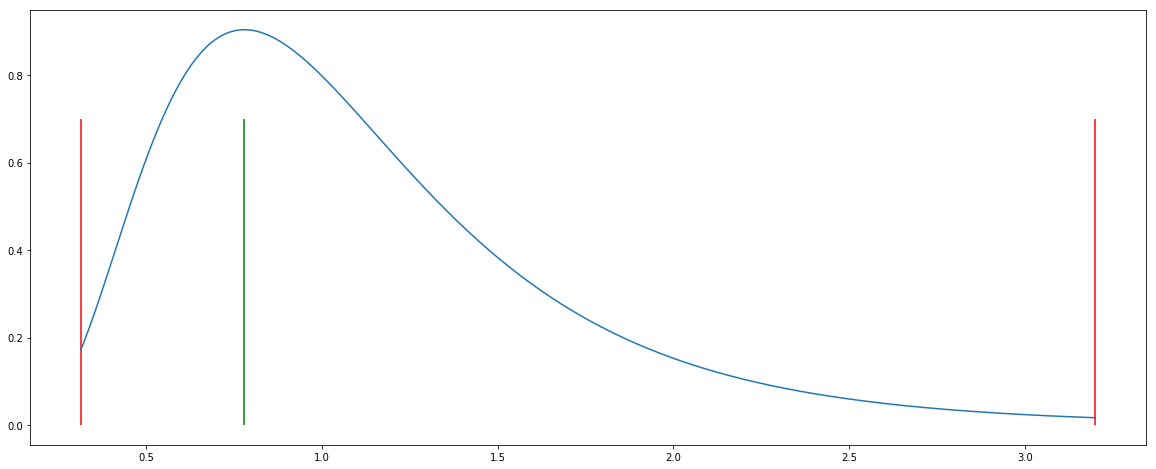

In [4]:
x_values = np.linspace(logn_gen.a, logn_gen.b, 1000)
y = []
for x in x_values:
    y.append(logn_gen._pdf_(x))

y_values = np.array(y) 
plt.figure(figsize=(20, 8))
plt.plot(x_values, y_values)
plt.vlines(logn_gen.a, 0, .7, colors='red')
plt.vlines(logn_gen.b, 0, .7, colors='red')
plt.vlines(logn_gen.max_x, 0, .7, colors='green')
plt.show() 

In [5]:
seq = logn_gen.generate(1000)

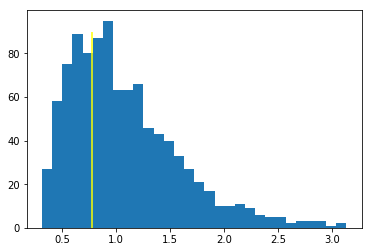

In [6]:
plt.hist(seq, bins=30)
plt.vlines(logn_gen.max_x, 0, 90, colors='yellow')
plt.show() 

---

## <center> Lognormal generator

### Define dict of experiments

Key is name of experiment, and values is parameters of experiment

In [110]:
experiment_params = {
    'mu0_sigma1' : {'mu' : 0, 'sigma' : 1},
    'mu2_sigma1' : {'mu' : 2, 'sigma' : 1},
    'mu2_sigma01' : {'mu' : 2, 'sigma' : 0.1}
}

desirable_sizes = [50, 200, 1000]

### Plot the probability density function (a.k.a. pdf)

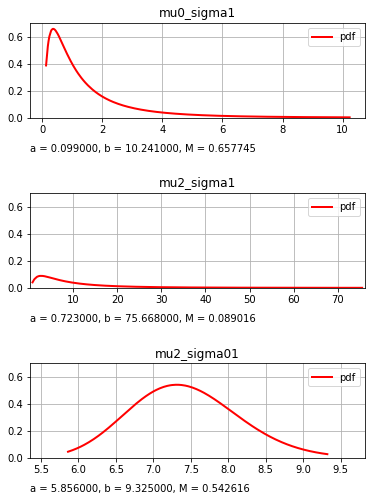

In [55]:
# build a graph of theory probability distribution function 
num_of_points = 500
fig, axes = plt.subplots(len(experiment_params), 1, figsize=(6, 8))
plt.subplots_adjust(hspace=0.8, wspace=0.5)
i = 0

for name, params in experiment_params.items():
    mu, sigma = params['mu'], params['sigma']
    logn_gen = Lognormal_gen(mu=mu, sigma=sigma) 
    x = logn_gen.a + np.random.uniform(size=num_of_points) * (logn_gen.b - logn_gen.a)
    x = sorted(x)
    y = logn_gen._pdf_(x)
    
    ax = axes[i]
    ax.set_xlim(logn_gen.a - 0.5, logn_gen.b + 0.5)
    ax.set_ylim(0, 0.7)
    ax.plot(x, y, color='red', label='pdf', linewidth=2)
    
    ax.text(logn_gen.a - 0.5, -0.25, 'a = %f, b = %f, M = %f' % (logn_gen.a, logn_gen.b, logn_gen.max_y))
    
    ax.set_title(name)
    ax.legend()
    ax.grid() 
    
    i+=1

plt.show()

### Perform experiments with log-normal distribution

Number of iterations: 413
Number of iterations: 1253
Number of iterations: 6769
Number of iterations: 335
Number of iterations: 1379
Number of iterations: 6725
Number of iterations: 86
Number of iterations: 409
Number of iterations: 1938


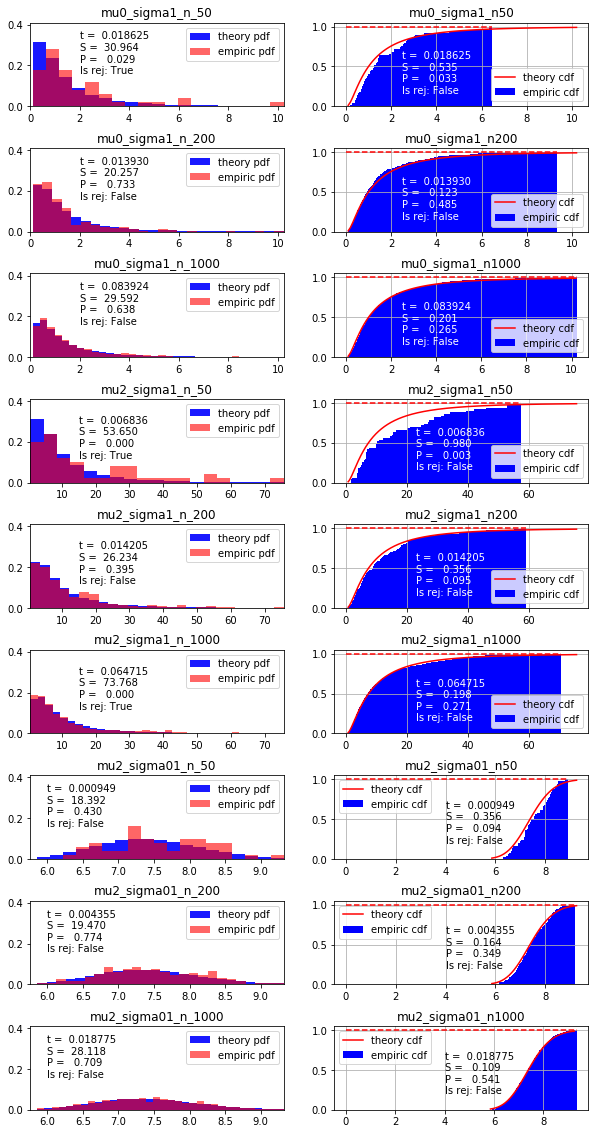

In [134]:
fig, axes = plt.subplots(len(experiment_params) * len(desirable_sizes), 2, figsize=(10, 20))
plt.subplots_adjust(hspace=.5, wspace=0.2) 

plotted_row = 0

text_coords = np.array([
    [[2, 0.16], [2.5, 0.16]],
    [[15, 0.12], [23, 0.16]],
    [[6, 0.16], [4, 0.2]]
    ])


for name, params in experiment_params.items():
    for idx, size in enumerate(desirable_sizes):
        logn_gen = Lognormal_gen(mu=params['mu'], sigma=params['sigma'])
        start = time.time()
        seq = logn_gen.generate(size)
        print('Number of iterations: %d' % logn_gen._iters)
        end = time.time()
        
        taken_time = end - start
        
        # calculate empirical probability row
        k = int(5 * np.log(size))
        upper_bound = logn_gen.b 
        interval_width = (logn_gen.b - logn_gen.a) / k
        empiric_freq, _ = param._freqs(seq, logn_gen.a, logn_gen.b, k, normalized=True)
        
        # build array of left bounds of intervals
        left_bounds = np.arange(k) * interval_width + logn_gen.a
        
        # calculate theory probability row
        theory_prob_row = []
        for i in range(k):
            F_x2 = logn_gen._cdf_(logn_gen.a + (i + 1) * interval_width)
            F_x1 = logn_gen._cdf_(logn_gen.a + i * interval_width)
            theory_prob_row.append(F_x2 - F_x1)
        theory_prob_row = np.array(theory_prob_row)
        
        # perform test
        chi_is_rej, chi_s, chi_p = param.chisquare(empiric_freq, theory_prob_row, size, 0.05)
        kol_is_rej, kol_s, kol_p = noparam.kramer_mizes(seq, logn_gen._cdf_)
        
        # plots
        ax = axes[plotted_row]
        text_x = 1 
        # 1) shisquare plots
        ax[0].set_ylim(-0.0, 0.41)
        ax[0].set_xlim(logn_gen.a - .1, logn_gen.b)
        ax[0].bar(left_bounds, 
                  theory_prob_row, 
                  label='theory pdf', 
                  width=interval_width, 
                  color='blue', 
                  alpha=0.9, 
                  align='edge')
        ax[0].bar(left_bounds, 
                empiric_freq, 
                label='empiric pdf', 
                width=interval_width,
                color='red', 
                alpha=0.6,
                align='edge')
        ax[0].set_title(name + '_n_' + str(size))
        ax[0].legend() 
        text_info = ('t = % 7.6f\nS = % 7.3f\nP = % 7.3f\nIs rej: %r' % (taken_time, chi_s, chi_p, chi_is_rej))
        ax[0].text(text_coords[plotted_row//3, 0, 0], 
                   text_coords[plotted_row//3, 0, 1], 
                   text_info, fontdict={'size': 10})
        
        
        # 2) kolmogorov plots
        # 2.0) calculate probability row
        lower_bound = 0
        upper_bound = max(seq)
        ax[0].set_xlim(logn_gen.a - .1, logn_gen.b)
        
        # 2.1) plot bar of empirical probability row
        empiric_line_X_values = sorted(seq.copy())
        empiric_line_Y_values = np.arange(1, len(seq) + 1) / len(seq)
        widths = np.ediff1d(empiric_line_X_values)
        widths = np.append(widths, 0.1)
        ax[1].bar(empiric_line_X_values, 
                  empiric_line_Y_values, 
                  widths, 
                  color='blue', 
                  label='empiric cdf', 
                  linewidth=2, 
                  align='edge')

        # 2.2) build a graph of theory cumulative distribution function 
        theory_line_X_values = np.arange(start=logn_gen.a, stop=logn_gen.b, step=0.1)
        theory_line_Y_values = np.apply_along_axis(logn_gen._cdf_, 0, theory_line_X_values)
        ax[1].plot(theory_line_X_values, theory_line_Y_values, color='red', label='theory cdf', linewidth=1.5)

        # 2.3) y = 1 border
        ax[1].hlines(1, 0, upper_bound + 0.1, colors='red', linestyles='dashed')

        # show plots/graphs
        text_color = 'white' if plotted_row//3 < 2 else 'black'
        ax[1].grid()
        ax[1].legend() 
        ax[1].set_title(name + '_n' + str(size))
        text_info = ('t = % 7.6f\nS = % 7.3f\nP = % 7.3f\nIs rej: %r' % (taken_time, kol_s, kol_p, kol_is_rej))
        ax[1].text(text_coords[plotted_row//3, 1, 0], 
                   text_coords[plotted_row//3, 1, 1], 
                   text_info, 
                   fontdict={
                       'size': 10,
                       'color' : text_color})
        
        plotted_row += 1
        
        
plt.show() 